In [233]:
import pandas as pd
import numpy as np
from utils.features import DataGame
from greenpyce.feature_engineering import TargetEncoder
from greenpyce.feature_engineering import onehot
from greenpyce.feature_engineering import RankCategorical
from greenpyce.feature_engineering import LabelCount
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import xgboost as xgb 
from time import time

# Funções para analise de acuracia

In [234]:
def complete_report(y_test, y_pred):
    print("*********************************")
    print("Accuracy: {0:.2f}".format(accuracy_score(y_test, y_pred)))
    print("Precision: {0}".format(metrics.precision_score(y_test, y_pred)))
    print("Recall: {0}".format(metrics.recall_score(y_test, y_pred)))
    print("F1-Score: {0}".format(metrics.f1_score(y_test, y_pred)))
    conf_m = confusion_matrix(y_test, y_pred)
    print(conf_m)
    try: 
        print("Roc Area: {0}".format(metrics.roc_auc_score(y_test, y_pred))) 
        roc_curve_label(y_test, y_pred)
    except:
        print("--")
    print("*********************************")
    
    return metrics.roc_auc_score(y_test, y_pred)
        
def roc_curve_label(y_test, y_pred):
    plt.figsize=(10,6)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='RT + LR')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()


In [376]:
pd.set_option('display.width', 200)

In [377]:
game_train = DataGame("data/train.csv", nrows=100000, nusers=10000)

In [378]:
df_train = game_train.compute_features(["nmidia", "nartist", "nplatform", "flow_noflow"])
game_train.df.head()

   genre_id   ts_listen  media_id  album_id  context_type  release_date  platform_name  platform_family  media_duration  listen_type  user_gender  user_id  artist_id  user_age  is_listened
0     25471  1480597215    222606     41774            12      20040704              1                0             223            0            0     9241      55164        29            0
1     25571  1480544735    250467     43941             0      20060301              2                1             171            0            0    16547      55830        30            1
2        16  1479563953    305197     48078             1      20140714              2                1             149            1            1     7665       2704        29            1
3         7  1480152098    900502     71521             0      20001030              0                0             240            0            1     1580        938        30            0
4         7  1478368974    542335     71718            

# Organizando as features coletadas pela API do Deezer

In [634]:
df_artist = pd.read_csv("data/deezer_API_artist_features.csv", sep=";")
df_media = pd.read_csv("data/deezer_API_media_features.csv", sep=";")

In [635]:
df_final = pd.merge(game_train.df, df_artist, on="artist_id")
df_final = pd.merge(df_final, df_media, on="media_id")

In [636]:
df_final.columns

Index([u'genre_id', u'ts_listen', u'media_id', u'album_id', u'context_type', u'release_date', u'platform_name', u'platform_family', u'media_duration', u'listen_type', u'user_gender', u'user_id',
       u'artist_id', u'user_age', u'is_listened', u'artist_albuns', u'artist_fans', u'artist_radio', u'media_bpm', u'media_rank'],
      dtype='object')

In [748]:
df_game_copy = df_final.copy()

In [749]:
df_game_copy["year"] = df_game_copy.apply(lambda row: int(str(row["release_date"])[0:4]), axis=1)

In [750]:
# create a new categorical variable for year
bins = [1900, 1970, 1990, 2000, 2006, 2012, 2017]
group_names = ["release_50s", "release_90s", "release_2000s", "release_2006", "release_2012", "release_2016"]
df_game_copy["categories"] = pd.cut(df_game_copy["year"], bins, labels=group_names)

In [751]:
# create a new categorical variable for the user age
bins = [10, 18, 24, 28, 40]
group_names = ["young", "teenagers", "fresh_graduated", "adults"]
df_game_copy["cat_user_age"] = pd.cut(df_game_copy["user_age"], bins, labels=group_names)

In [752]:
bins = [0, 1, 70]
group_names = ["context_playlist", "context_album"]
df_game_copy["cat_context_type"] = pd.cut(df_game_copy["context_type"], bins, labels=group_names)

In [753]:
bins = [0, 10000, 60000, 100000, 600000, 1000000]
group_names = ["low_pop", "avg_pop", "pop", "max_pop", "sup_pop"]
df_game_copy["artist_fans"] = pd.cut(df_game_copy["artist_fans"], bins, labels=group_names)

In [754]:
df_game_copy["artist_fans"].value_counts()

max_pop    55381
low_pop    12621
avg_pop     7948
sup_pop     3479
pop         2961
Name: artist_fans, dtype: int64

In [755]:
bins = [0, 200000, 400000, 800000, 1000000]
group_names = ["bad_rank", "avg_rank", "good_rank", "great_rank"]
df_game_copy["media_rank"] = pd.cut(df_game_copy["media_rank"], bins, labels=group_names)

In [756]:
df_game_copy["media_rank"].value_counts()

good_rank     54163
great_rank    31411
avg_rank      14064
bad_rank        343
Name: media_rank, dtype: int64

In [757]:
bins = [0, 80, 150, 200]
group_names = ["low_bpm", "avg_bpm", "high_bpm"]
df_game_copy["media_bpm"] = pd.cut(df_game_copy["media_bpm"], bins, labels=group_names)

In [758]:
df_game_copy["media_bpm"].value_counts()

avg_bpm     82102
high_bpm    14509
low_bpm        71
Name: media_bpm, dtype: int64

In [759]:
bins = [0, 10, 20, 60, 600]
group_names = ["low_nalbum", "avg_nalbum", "good_nalbum", "great_nalbum"]
df_game_copy["artist_albuns"] = pd.cut(df_game_copy["artist_albuns"], bins, labels=group_names)

In [760]:
df_game_copy["artist_albuns"].value_counts()

avg_nalbum      48444
good_nalbum     24606
low_nalbum      19250
great_nalbum     5134
Name: artist_albuns, dtype: int64

In [761]:
df_train2 = df_train.reset_index(level=0)
df_game = pd.merge(df_game_copy, df_train2, on="user_id")

In [762]:
## Colunas que contem informacoes relevantes para uma primeira analise
categorical_cols = ["genre_id", "media_id", "album_id", "context_type", "release_date", "platform_name", "platform_family", "listen_type", "user_gender",
                    "user_id", "artist_id", "categories", "cat_user_age", "cat_context_type", "media_bpm", "media_rank", "artist_albuns", "artist_radio",
                    "artist_fans"]
target = "is_listened"

# Strategy
1. Apply onehot to categorical with few classes
2. Rank categories to artist_id
3. Target encoder for context and genre
4. Discard media, album, release date and user_id

## Description of categorical variables

In [763]:
# For now lets only replace all NAN values for zero
df_game.replace([np.inf, -np.inf], np.nan, inplace=True)
df_game.fillna(0, inplace=True)

In [764]:
for col in categorical_cols:
    print("{}: {}".format(col, len(df_game[col].unique())))

genre_id: 312
media_id: 4608
album_id: 1517
context_type: 58
release_date: 1065
platform_name: 3
platform_family: 3
listen_type: 2
user_gender: 2
user_id: 10000
artist_id: 1776
categories: 6
cat_user_age: 4
cat_context_type: 3
media_bpm: 4
media_rank: 5
artist_albuns: 5
artist_radio: 2
artist_fans: 6


In [765]:
cols_for_onehot = ["platform_name", "platform_family", "listen_type", "user_gender", "categories", "cat_user_age", "cat_context_type",
                   "media_bpm", "artist_fans", "media_rank", "artist_albuns"]
cols_for_target_encoder = ["genre_id", "album_id"]
#cols_for_rank = ["artist_id"]

In [766]:
te = TargetEncoder(cols_for_target_encoder, "is_listened", inplace=True)
te.fit(df_game)
te.transform(df_game)

In [767]:
#rc = RankCategorical(cols_for_rank)
#rc.fit(df_game)
#rc.transform(df_game)

In [768]:
df_game = onehot(df_game, cols_for_onehot)

In [769]:
# cols to drop
cols_to_drop = ["media_id", "user_id", "ts_listen", "media_duration", "year",
                "release_date", "user_age", "context_type", "artist_id"]
df_game.drop(cols_to_drop, axis=1, inplace=True)
df_game.fillna(0, inplace=True)

In [770]:
features = [col for col in df_game.columns.values if col != target]
features

['genre_id',
 'album_id',
 'artist_radio',
 'nmidia_with_flow',
 'nmidia_regular',
 'nmidia_with_flow_listened',
 'nmidia_regular_listened',
 'nmidia_max_repeat',
 'nartist_with_flow',
 'nartist_regular',
 'nartist_with_flow_listened',
 'nartist_regular_listened',
 'nplatform_with_flow',
 'nplatform_regular',
 'nplatform_with_flow_listened',
 'nplatform_regular_listened',
 'nmidia_noflow',
 'nmidia_noflow_sucess',
 'nmidia_noflow_sucess_PROP',
 'nmodia_flow',
 'nmidia_flow_success',
 'midia_flow_success_PROP',
 'PROP_flow_PROP_noflow',
 'qtd_flow_noflow_PROP',
 'nmidia_with_flow_listened_PROP',
 'nmidia_regular_listened_PROP',
 'nmidia_PROP_diff',
 'nartist_with_flow_listened_PROP',
 'nartist_regular_listened_PROP',
 'nartist_PROP_diff',
 'platform_name_1',
 'platform_name_2',
 'platform_family_1',
 'platform_family_2',
 'listen_type_1',
 'user_gender_1',
 'categories_release_2006',
 'categories_release_2012',
 'categories_release_2016',
 'categories_release_50s',
 'categories_release_

In [771]:
X_train,  X_test, y_train, y_test = train_test_split(df_game[features], df_game[target], test_size = 0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3)

Implementando o XGBOOST

In [772]:
xg_train = xgb.DMatrix(X_train, label=y_train, missing=np.NaN)
xg_test = xgb.DMatrix(X_test, label=y_test, missing=np.NaN)
xg_val = xgb.DMatrix(X_val, label=y_val, missing=np.NaN)

num_rounds = 10
param = {
      "max_depth": 30,
      "eta": 0.2,
      "silent": 0,
      "objective": "binary:logistic",
      "booster": "gbtree",
      "alpha": 1.0,
      "lambda": 0,
      "eval_metric": "auc"
}

watchlist = [(xg_train, "train"), (xg_val, "validation")]

bst = xgb.train(param,
                xg_train,
                num_rounds,
                watchlist,
                early_stopping_rounds=4)

yprob = bst.predict(xg_test)

[9]	train-auc:0.944464	validation-auc:0.864223


[8]	train-auc:0.942356	validation-auc:0.863636


[7]	train-auc:0.940293	validation-auc:0.86376


[6]	train-auc:0.937841	validation-auc:0.863494


[5]	train-auc:0.935234	validation-auc:0.863074


[4]	train-auc:0.931887	validation-auc:0.862247


[3]	train-auc:0.928753	validation-auc:0.861521


[2]	train-auc:0.925193	validation-auc:0.860767


[1]	train-auc:0.920192	validation-auc:0.858774


Will train until validation-auc hasn't improved in 4 rounds.


Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.



[0]	train-auc:0.91037	validation-auc:0.852646


0.75088269469693714

*********************************


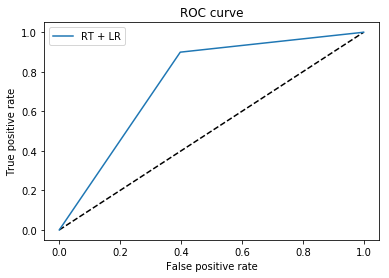

[[1510  996]
 [ 588 5246]]
*********************************
Accuracy: 0.81
Precision: 0.84043575777
Recall: 0.899211518684
F1-Score: 0.868830738655
[[1510  996]
 [ 588 5246]]
Roc Area: 0.750882694697


In [773]:
y_pred = [1 if y > 0.5 else 0 for y in yprob]
print(metrics.confusion_matrix(y_test, y_pred))

complete_report(y_test, y_pred)


In [774]:
import operator
importance = bst.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
for item in importance:
    print(item)

('album_id', 3025)
('nmidia_max_repeat', 2623)
('nmidia_regular', 1756)
('genre_id', 1744)
('nmidia_with_flow', 1559)
('nartist_regular', 834)
('cat_context_type_context_album', 816)
('nmidia_regular_listened_PROP', 750)
('nmidia_with_flow_listened_PROP', 747)
('media_rank_good_rank', 696)
('user_gender_1', 646)
('nartist_with_flow', 637)
('nartist_with_flow_listened_PROP', 601)
('nartist_regular_listened_PROP', 568)
('cat_user_age_teenagers', 563)
('media_bpm_avg_bpm', 531)
('cat_user_age_fresh_graduated', 507)
('platform_name_1', 413)
('artist_fans_max_pop', 389)
('nmidia_PROP_diff', 382)
('artist_albuns_avg_nalbum', 377)
('artist_albuns_good_nalbum', 338)
('media_rank_great_rank', 313)
('nartist_PROP_diff', 282)
('categories_release_2016', 279)
('nplatform_regular', 268)
('media_rank_avg_rank', 267)
('artist_fans_low_pop', 259)
('nartist_regular_listened', 257)
('categories_release_2012', 248)
('nmidia_with_flow_listened', 242)
('platform_name_2', 220)
('nartist_with_flow_listened',